shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
(1024, 1024)


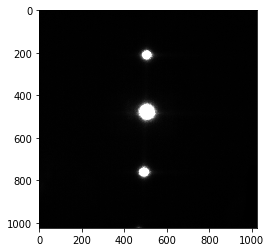

(1080, 1920)
TIME:  0.42433595657348633


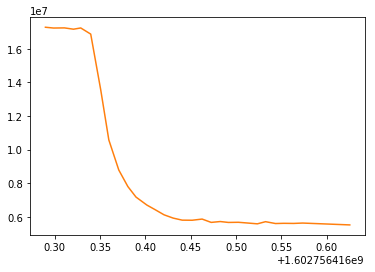

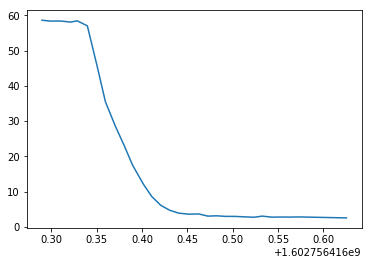

In [70]:
# IMPORTING PACKAGES REQUIRED TO RUN THE EXPERIMENT

import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import csv
import time
from pypylon import pylon
import cv2
import copy
import os
from os.path import isfile, join
import sys
import argparse

# TAKING COMMAND LINE ARGUMENTS

# total arguments 
n = len(sys.argv) 
print("Total arguments passed:", n) 
  
# Arguments passed 
print("\nName of Python script:", sys.argv[0]) 
  
print("\nArguments passed:", end = " ")
for i in sys.argv:
    print(i, end = " ")

date = str(sys.argv[1])
month = str(sys.argv[2])
sidelength = int(sys.argv[3])
datemonth = date + '_' + month

# CREATING OUTPUT FOLDER TO STORE DATA

main_dir = "slm_response_" + datemonth
os.mkdir(main_dir)

# DEFINING HORIZONTAL BINARY GRATING FUNCTION
def grating(shape):
    mask = np.zeros(shape)
    
    idx = [2*i for i in range(shape[0]//2)]
    mask[idx,:]=128
    
    return mask
###############################################


# EXPERIMENT TO CAPTURE TARGET IMAGE

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
showSLMPreview(slm, scale=0.0)


# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px

size = [sidelength, sidelength]

data = slmdisplaysdk.createFieldUChar(size[1],size[0])
#data = slmdisplaysdk.createFieldUChar(512,512)
size = data.shape
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = 2*np.pi*grating(data.shape)/256
print(data)
error = slm.showPhasevalues(data)

camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

#camera.OffsetX.SetValue(600)
#camera.OffsetY.SetValue(0)
#camera.Width.SetValue(2048-600)
#camera.Height.SetValue(1088-88)
numberOfImagesToGrab = 1
camera.StartGrabbingMax(numberOfImagesToGrab)

while camera.IsGrabbing():
   
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

    if grabResult.GrabSucceeded():
        # Access the image data.
        img = np.asarray(grabResult.Array) #.reshape((grabResult.Height, grabResult.Width))
        
        print(img.shape)

        

    grabResult.Release()
    
print(img.shape)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()    
camera.Close()


np.save(main_dir + "/target"+ str(size[0]) + '_' + datemonth, img)
img = np.load(main_dir + "/target"+ str(size[0]) + '_' + datemonth + '.npy')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
print(img.shape)
plt.show()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None


# EXPERIMENT TO MEASURE RESPONSE TIME OF THE SLM W.R.T THE CAPTURED IMAGE AND BROADCASTED GRATING ABOVE

# INITIALIZING INSTRUMENTS (CAMERA AND SLM)
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)

# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

sizerand = (dataHeight,dataWidth)

# Initialize random binary bitmap, and show it on the SLM:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = np.pi*(np.sign(np.random.normal(0,1,sizerand)+1e-7) + 1)/2
#print(data)
error = slm.showPhasevalues(data)

# DEFINING COST FUNCTION
def cost(I_target, I_camera):
    return np.sum((abs(I_target-I_camera))**2)/np.size(I_target)

# Set this appropriately, can load the .npy file into this
TargetIntensity = np.load(main_dir '/target' + str(size[0]) + '_' + datemonth + '.npy')
print(TargetIntensity.shape)
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.title("Target Image captured by camera")
plt.savefig(main_dir + "/target" + str(size[0]) + '_' + datemonth + ".png")
plt.show()

numberOfImagesToGrab = 30

count = 0
COST = []
img = []
TIME = []
E = []
time_start = time.time()

# Reserve memory for grating to be shown, then show grating
data2 = slmdisplaysdk.createFieldUChar(size[0],size[1])
data2 = np.pi*grating(size)/128
time_start = time.time()

error = slm.showPhasevalues(data2) # SHOW GRATING 
camera.StartGrabbingMax(numberOfImagesToGrab)
while camera.IsGrabbing():
    grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
    if grabResult.GrabSucceeded():
        # Access the image data.
        img.append(grabResult.Array)
        TIME.append(time.time())
    else:
        print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
    grabResult.Release()
    count += 1
    #cv2.imwrite('with_phase_06_10/with_phase'+ str(iter) + '.png', img[-1])
    
    
time_end = time.time()
print(data2.shape)
print("TIME: ", time_end-time_start)

fps = 1
sizevid = (img[1]).shape
pathOut = main_dir + '/response' + string(size[0]) + datemonth + '.avi'
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, sizevid)



for i in range(30):
   COST.append(cost(TargetIntensity, img[i]))
   E.append(np.sum(img[i]))
   gray = cv2.normalize(img[i], None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
   gray_3c = cv2.merge([gray, gray, gray])
   out.write(gray_3c)
   
out.release()
plt.plot(TIME, E)
plt.show()
plt.plot(TIME, COST)
plt.show()

print("COST = ", COST)
print("Energy = ", E)
print("TIME = ", TIME)
time2 = []
for i in TIME:
    current_milli_time = lambda: int(round((i - TIME[0])*1000))
    time2.append(current_milli_time())
    
print("Time in milliseconds = ", time2)

# CREATING AND SAVING PLOTS OF THE RESPONSE

fig, ax = plt.subplots(2,1)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.tight_layout(pad=4)
fig.suptitle("Response time of SLM when a binary horizontal grating of " + str(size[0]) + "x" + str(size[1]) + "pixels is uploaded", fontsize=20)
ax[0].plot(time2, COST)
ax[0].set_xlabel("Time in seconds", fontsize=15)
ax[0].set_ylabel("Cost function", fontsize=15)
ax[1].plot(time2, E)
ax[1].set_xlabel("Time in seconds", fontsize=15)
ax[1].set_ylabel("Energy", fontsize=15)

plt.savefig(main_dir + "/response" + str(size[0]) + "_" + datemonth + ".png")
plt.show()

plt.imshow(data2, cmap='gray')
plt.xlabel("Column number")
plt.ylabel("Row number")
plt.title("Grating shown on SLM")
plt.colorbar()
plt.savefig(main_dir + "/grating" + str(size[0]) + "_" + datemonth + ".png")


# CLOSING DOWN THE INSTRUMENTS

camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None

In [81]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None

AssertionError: b'The SLM could not be initialized or was disconnected.'

In [71]:
print(COST)

[58.5800085067749, 58.34235382080078, 58.356231689453125, 58.05553913116455, 58.400604248046875, 56.99040985107422, 45.381287574768066, 35.44887924194336, 28.54824924468994, 22.89918804168701, 17.513318061828613, 12.106681823730469, 8.693893432617188, 6.169550895690918, 4.750556945800781, 3.939894676208496, 3.6500205993652344, 3.7191762924194336, 3.102902412414551, 3.186762809753418, 3.030062675476074, 3.0201025009155273, 2.912947654724121, 2.7822065353393555, 3.099787712097168, 2.8050155639648438, 2.84389591217041, 2.824748992919922, 2.8681564331054688, 2.5909500122070312]


In [72]:
print(TIME)

[1602756416.2898102, 1602756416.2987974, 1602756416.31078, 1602756416.3207605, 1602756416.3287542, 1602756416.3397446, 1602756416.3507197, 1602756416.3596988, 1602756416.3706875, 1602756416.3806767, 1602756416.3896523, 1602756416.401639, 1602756416.4106255, 1602756416.420607, 1602756416.4305909, 1602756416.440581, 1602756416.4515572, 1602756416.4625404, 1602756416.472528, 1602756416.4825096, 1602756416.4915118, 1602756416.502482, 1602756416.5114653, 1602756416.5234501, 1602756416.5324328, 1602756416.543417, 1602756416.5523992, 1602756416.5633855, 1602756416.5733762, 1602756416.6253]


In [73]:
time2= []
for i in TIME:
    time2.append(i - time_start)
    
print(time2)

[0.08785533905029297, 0.09684252738952637, 0.1088252067565918, 0.1188056468963623, 0.1267993450164795, 0.13778972625732422, 0.14876484870910645, 0.1577439308166504, 0.1687326431274414, 0.17872190475463867, 0.1876974105834961, 0.19968414306640625, 0.20867061614990234, 0.21865224838256836, 0.2286360263824463, 0.23862624168395996, 0.2496023178100586, 0.2605855464935303, 0.27057313919067383, 0.28055477142333984, 0.28955698013305664, 0.30052709579467773, 0.3095104694366455, 0.32149529457092285, 0.3304779529571533, 0.3414621353149414, 0.35044431686401367, 0.36143064498901367, 0.37142133712768555, 0.42334508895874023]


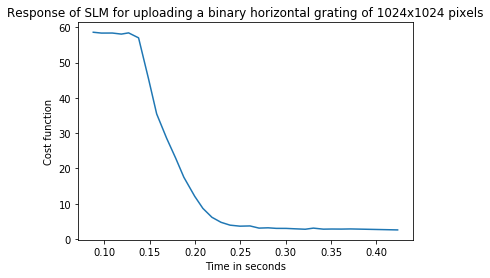

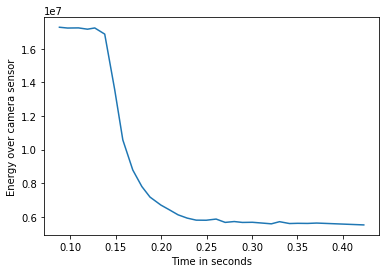

In [74]:
plt.plot(time2, COST)
plt.xlabel("Time in seconds")
plt.ylabel("Cost function")
plt.title("Response of SLM for uploading a binary horizontal grating of 1024x1024 pixels")
plt.show()
plt.plot(time2, E)
plt.xlabel("Time in seconds")
plt.ylabel("Energy over camera sensor")
plt.title("")
plt.show()

In [75]:
print(E)

[17274558, 17227351, 17235871, 17158562, 17231977, 16867211, 13570574, 10575841, 8786026, 7803970, 7177498, 6703149, 6432135, 6122030, 5928275, 5805698, 5800121, 5869938, 5672138, 5722970, 5670004, 5678862, 5640286, 5587048, 5714530, 5604539, 5617698, 5611073, 5632811, 5522335]


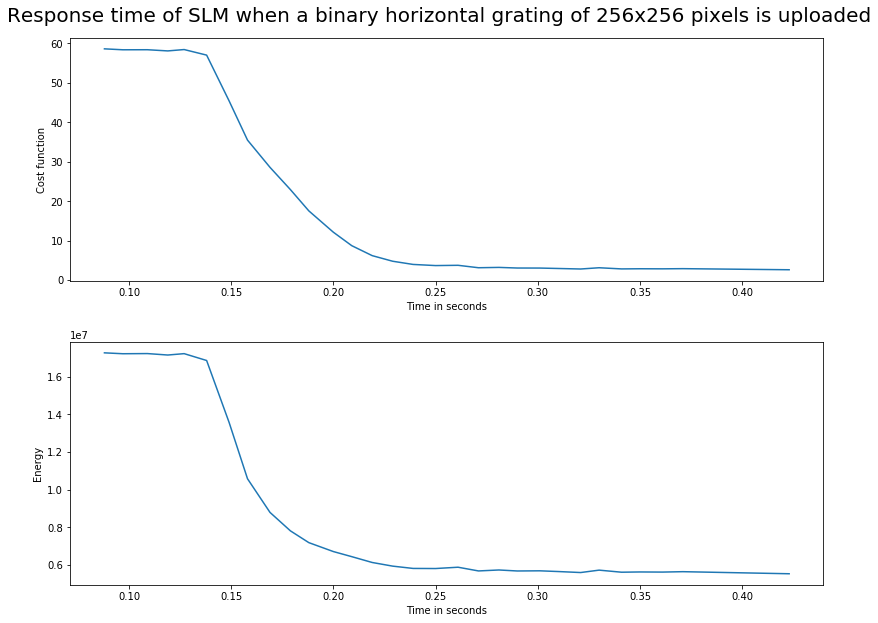

In [78]:
fig, ax = plt.subplots(2,1)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.tight_layout(pad=4)
fig.suptitle("Response time of SLM when a binary horizontal grating of 256x256 pixels is uploaded", fontsize=20)
ax[0].plot(time4, COST)
ax[0].set_xlabel("Time in seconds")
ax[0].set_ylabel("Cost function")
ax[1].plot(time4, E)
ax[1].set_xlabel("Time in seconds")
ax[1].set_ylabel("Energy")

plt.savefig("256_response_15_10.png")

plt.show()

In [36]:
current_milli_time = lambda: int(round(TIME[0])*1000)
current_milli_time()

1602753831000

In [35]:
current_milli_time = lambda: int(round(time.time() * 1000))
current_milli_time()

1602754702770

In [76]:
time3 = []
for i in time2:
    current_milli_time = lambda: int(round(i*1000))
    time3.append(current_milli_time())
    
print(time3)

[88, 97, 109, 119, 127, 138, 149, 158, 169, 179, 188, 200, 209, 219, 229, 239, 250, 261, 271, 281, 290, 301, 310, 321, 330, 341, 350, 361, 371, 423]


In [77]:
time4 =[]
for i in time3:
    time4.append(i/1000)
print(time4)

[0.088, 0.097, 0.109, 0.119, 0.127, 0.138, 0.149, 0.158, 0.169, 0.179, 0.188, 0.2, 0.209, 0.219, 0.229, 0.239, 0.25, 0.261, 0.271, 0.281, 0.29, 0.301, 0.31, 0.321, 0.33, 0.341, 0.35, 0.361, 0.371, 0.423]


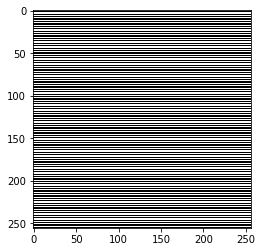

In [79]:
plt.imshow(data2, cmap='gray')

plt.savefig("grating_256_15_10.png")